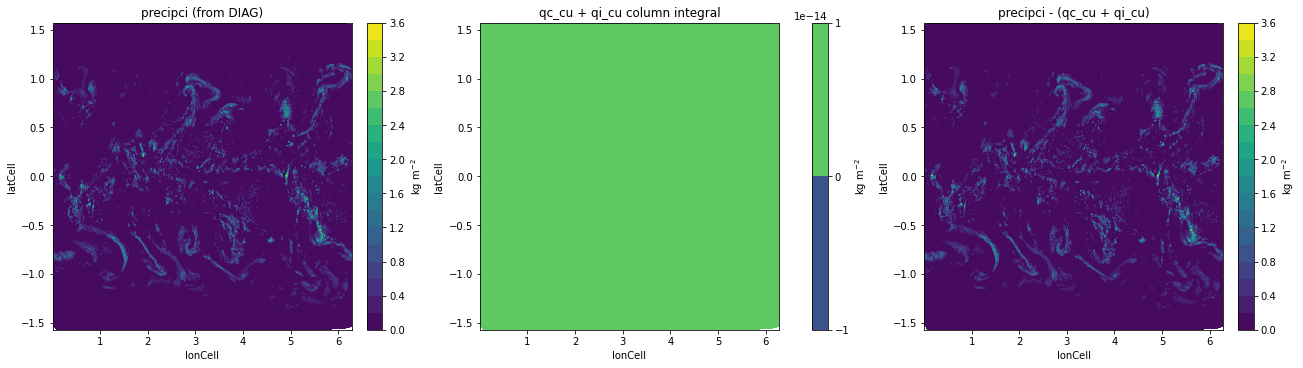

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Paths: qc, qi, qv, rho, zgrid in HIST file; precipci in DIAG file
# -------------------------------------------------------------------
hist_path = (
    "/pesq/dados/monan/users/lianet.hernandez/global_clm_2018-2019/"
    "MONAN_HIST_G_MOD_GFS_2018111500_2018120900.00.00.x655362L55.nc"
)
diag_path = hist_path.replace("HIST", "DIAG")

dsh = xr.open_dataset(hist_path)  # qc, qi, qv, rho, zgrid, latCell, lonCell
dsd = xr.open_dataset(diag_path)  # precipci, latCell, lonCell

# --- basic fields ---
qv  = dsh["qv"]        # (Time, nCells, nVertLevels), kg/kg
qc  = dsh["qc"]
qi  = dsh["qi"]
rho_d = dsh["rho"]     # dry air density, kg/m^3
z_ifc = dsh["zgrid"]   # (nCells, nVertLevelsP1), m (layer interfaces)

lat = dsh["latCell"]   # (nCells,)
lon = dsh["lonCell"]   # (nCells,)

# --- layer thickness from interface heights ---
dz = z_ifc.diff("nVertLevelsP1")                       # (nCells, nVertLevels)
dz = dz.rename({"nVertLevelsP1": "nVertLevels"})       # match vertical dim name

# broadcast dz to 3D (Time, nCells, nVertLevels)
dz_3d = dz.broadcast_like(qc)

# moist air density  ρ_m = ρ_d * (1 + qv)
rho_m = rho_d * (1.0 + qv)

def column_integral(var):
    """∫ var * ρ_m * dz  over nVertLevels -> kg m^-2"""
    return (var * rho_m * dz_3d).sum("nVertLevels")

# --- column-integrated masses (kg m^-2) ---
qc_col = column_integral(qc)  # (Time, nCells)
qi_col = column_integral(qi)

# also for convective variables
if {"qc_cu", "qi_cu"}.issubset(dsh.variables):
    qc_cu_col = column_integral(dsh["qc_cu"])
    qi_cu_col = column_integral(dsh["qi_cu"])

# -------------------------------------------------------------------
# Retrieve precipci from DIAG file and compare
# -------------------------------------------------------------------
precipci = dsd["precipci"]  # (Time, nCells), expected kg m^-2

# choose a time index to plot
it = 0

precipci_2d = precipci.isel(Time=it)
#calc_precipci_2d = (qc_col + qi_col).isel(Time=it)
calc_precipci_2d = (qc_cu_col + qi_cu_col).isel(Time=it)

diff_2d = precipci_2d - calc_precipci_2d  # precipci - calculated_precipci

# -------------------------------------------------------------------
# Plot: 3 panels with tricontourf
#   1) precipci from file
#   2) qc+qi column integral
#   3) difference
# -------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

# panel 1: precipci
c1 = axes[0].tricontourf(lon.values, lat.values, precipci_2d.values, levels=21)
axes[0].set_title("precipci (from DIAG)")
axes[0].set_xlabel("lonCell")
axes[0].set_ylabel("latCell")
fig.colorbar(c1, ax=axes[0], label="kg m$^{-2}$")

# panel 2: qc + qi integral
c2 = axes[1].tricontourf(lon.values, lat.values, calc_precipci_2d.values, levels=21)
#axes[1].set_title("qc + qi column integral")
axes[1].set_title("qc_cu + qi_cu column integral")
axes[1].set_xlabel("lonCell")
axes[1].set_ylabel("latCell")
fig.colorbar(c2, ax=axes[1], label="kg m$^{-2}$")

# panel 3: difference
c3 = axes[2].tricontourf(lon.values, lat.values, diff_2d.values, levels=21)
#axes[2].set_title("precipci - (qc + qi)")
axes[2].set_title("precipci - (qc_cu + qi_cu)")
axes[2].set_xlabel("lonCell")
axes[2].set_ylabel("latCell")
fig.colorbar(c3, ax=axes[2], label="kg m$^{-2}$")

plt.show()